In [5]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, lfilter, find_peaks, welch, iirnotch
from scipy.integrate import cumtrapz
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [6]:
def tomV_byBitalino(ADC, n = 10, VCC = 3.3):
    volts = (((ADC/(2**n))-(1/2)) * VCC)/1009
    return volts*1000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def extract_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    amplitude = np.max(signal) - np.min(signal)
    fft_signal = np.fft.fft(signal)
    dominant_frequency = np.argmax(np.abs(fft_signal))
    peaks, _ = find_peaks(signal)
    duration = (peaks[-1]-peaks[0])/len(signal)
    power = np.sum(np.square(signal))/len(signal)
    kurtosis = np.sum((signal - mean)**4)/(len(signal)*std**4)
    coeffs = pywt.wavedec(signal, 'db4', level = 5)
    cA5,cD5,cD4,cD3,cD2,cD1 = coeffs
    wavelet = np.concatenate((cD1, cD2, cD3, cD4, cD5))
    rms = np.sqrt(np.sum(signal * signal)/len(signal))
    area = cumtrapz(signal)
    f,P = welch(signal,fs = 1000, window='hann', noverlap=0,nfft = int(256.))
    area_freq = cumtrapz(P,f,initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq > total_power/2)[0][0]]
    f_max = f[np.argmax(P)]
    features =  {'media': mean,
                 'desviacion_estandar': std,
                 'amplitud': amplitude,
                 'frecuencia_dominante': dominant_frequency,
                 'potencia': power,
                 'kurtosis': kurtosis,
                 'wavelet': wavelet,
                 'rms': rms,
                 'area': area,
                 'min_value': np.min(signal),
                 'max_value': np.max(signal),
                 'area_freq': area_freq,
                 'total_power': total_power,
                 'median_freq': median_freq,
                 'f_max': f_max                 
                 }
    return features

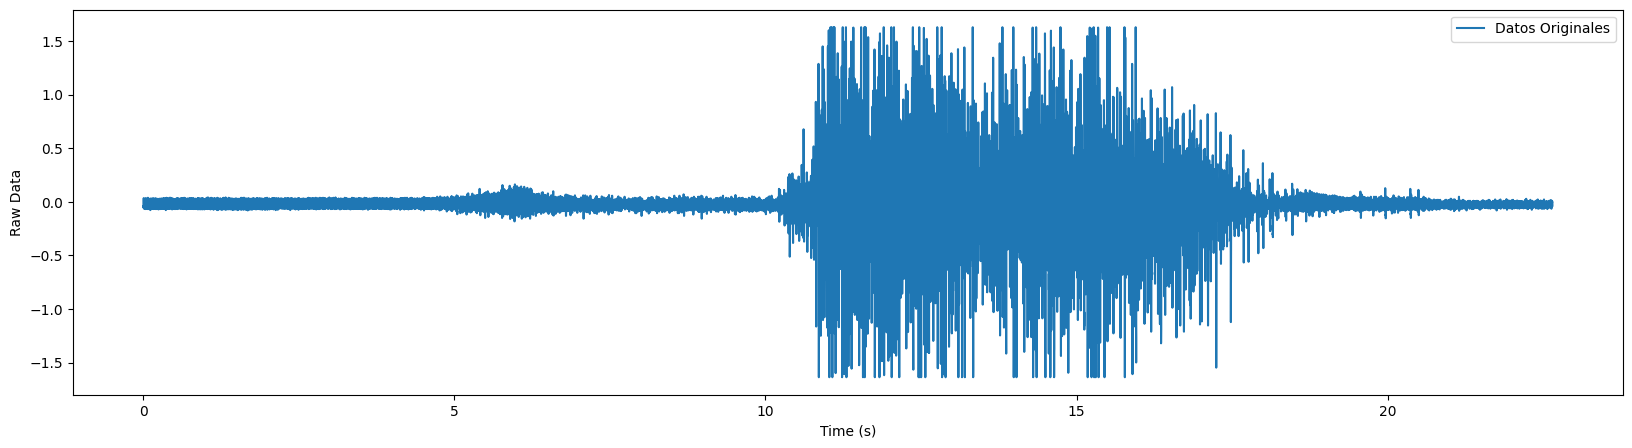

In [7]:
signal = np.genfromtxt('Biceps - Carlos' + ".txt", delimiter="\t")
signal = signal[:,-2]
signal = tomV_byBitalino(signal)
fs = 1000; ts = 1/fs # Bitalino's sampling rate
time = np.arange(len(signal))*ts
plt.figure(figsize=(20,5))
plt.plot(time, signal, label = 'Datos Originales')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


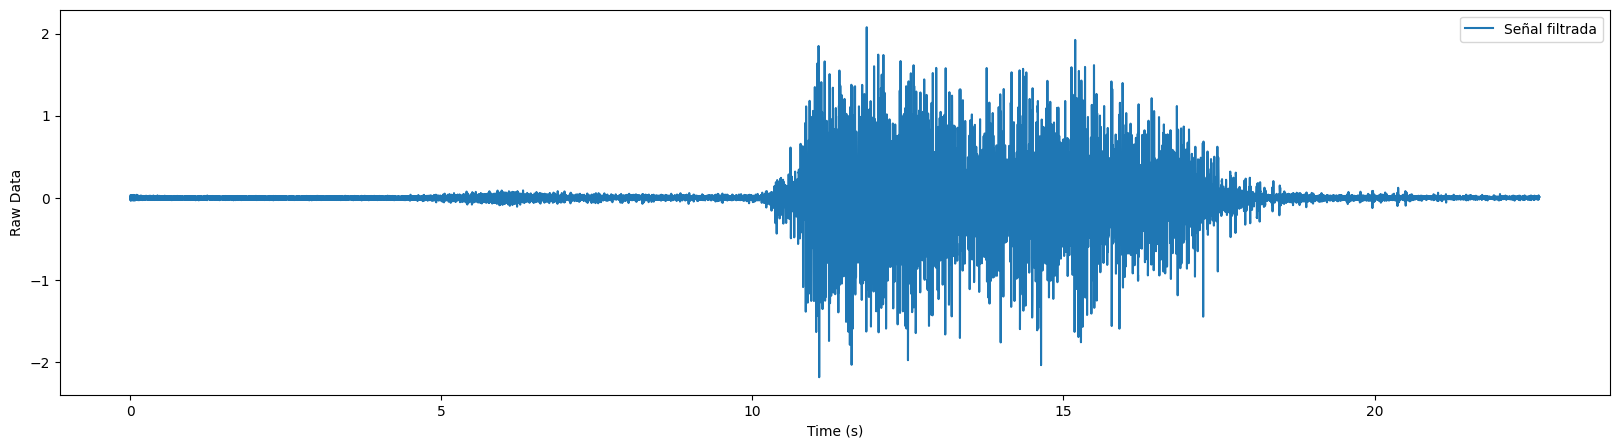

In [8]:
# Eliminacion de linea base
pre_pro_signal = signal - np.average(signal)

# Filtrado
low_cutoff = 10.0
high_cutoff = 300.0

smooth_signal = butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, fs)

b,c = iirnotch(60.0, 30.0, fs)
smooth_signal = filtfilt(b,c,smooth_signal)

plt.figure(figsize=(20,5))
plt.plot(time, smooth_signal, label = 'Señal filtrada')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


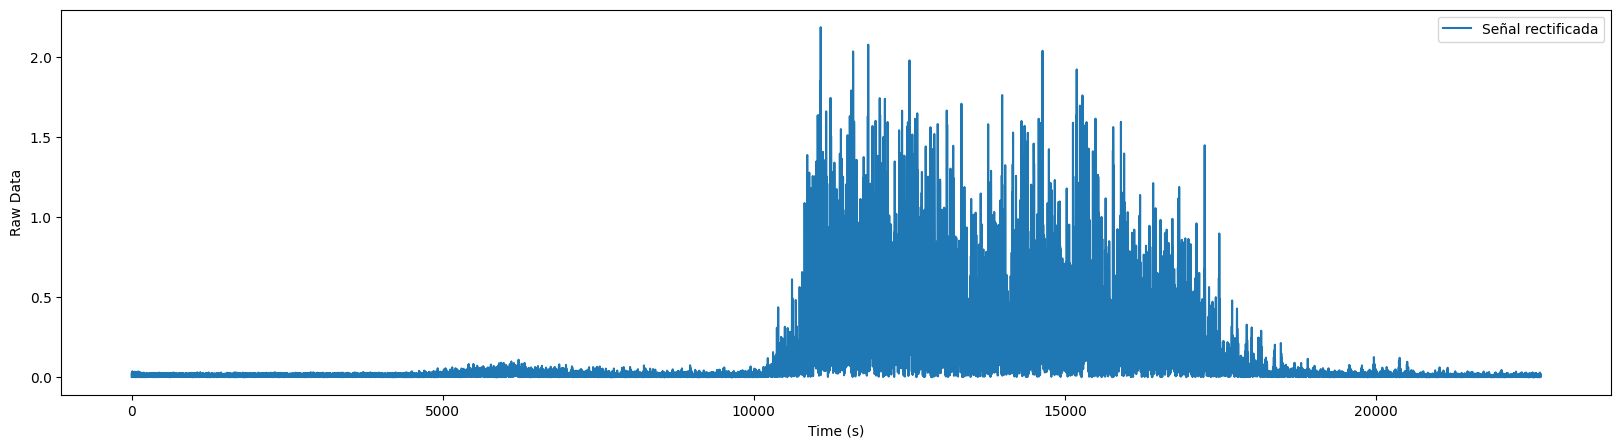

In [9]:
# Rectificación
emg_rectified = np.abs(smooth_signal)

plt.figure(figsize=(20,5))
plt.plot(emg_rectified, label = 'Señal rectificada')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


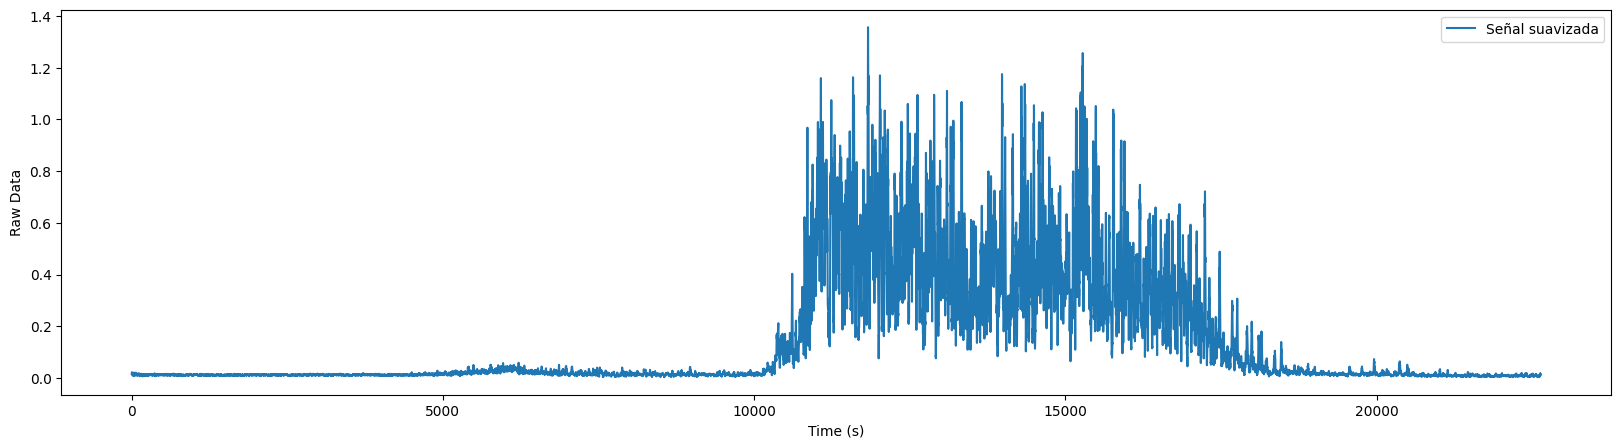

In [10]:
# Suavizado
window = 10  # Tamaño de la ventana para el suavizado
            
emg_smoothed = np.convolve(emg_rectified, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20,5))
plt.plot(emg_smoothed, label = 'Señal suavizada')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

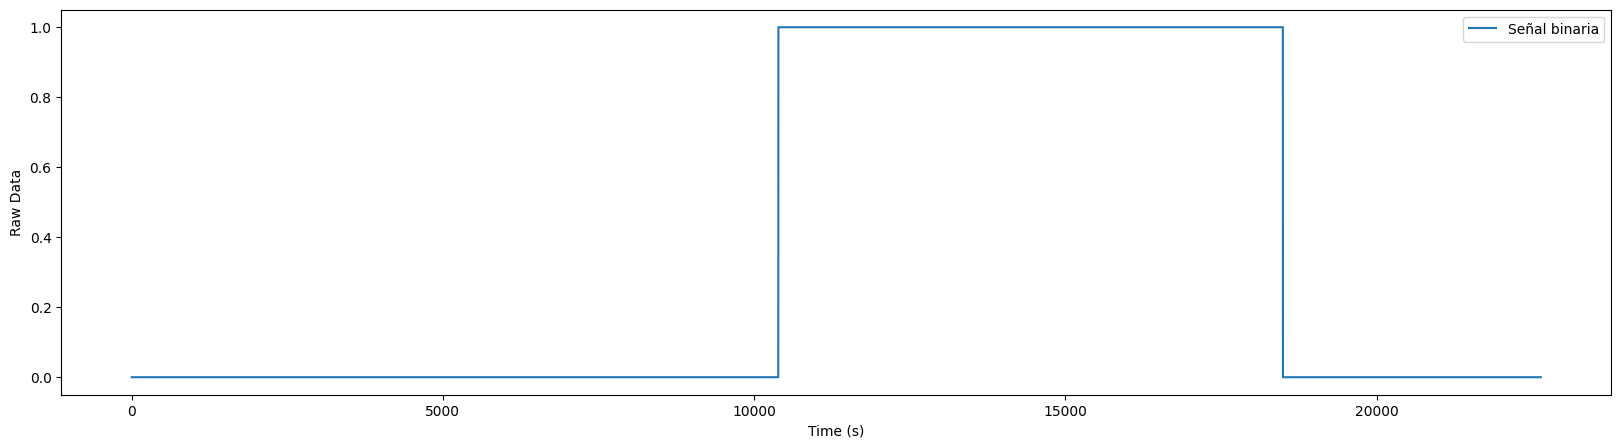

In [11]:
# Umbralización
threshold = 0.2  # Este valor depende de tu señal, puedes ajustarlo según tus necesidades

# Inicializa la señal binaria
emg_binary = np.zeros_like(emg_smoothed)

# Inicializa el estado de la actividad
activity = False

# Inicializa el contador del periodo de gracia
grace_period = 0
grace_duration = 500  # Duración del periodo de gracia en muestras

# Recorre la señal suavizada
for i in range(len(emg_smoothed)):
    # Si la señal cruza el umbral hacia arriba
    if emg_smoothed[i] > threshold and emg_smoothed[i-1] <= threshold:
        activity = True
        grace_period = 0
    # Si la señal cruza el umbral hacia abajo
    elif emg_smoothed[i] <= threshold and emg_smoothed[i-1] > threshold:
        if grace_period == 0:
            grace_period = i  # Comienza el periodo de gracia

    # Si estamos en el periodo de gracia
    if grace_period > 0:
        # Si la señal ha estado por debajo del umbral durante todo el periodo de gracia
        if i - grace_period >= grace_duration:
            activity = False  # Termina la actividad
            grace_period = 0  # Reinicia el periodo de gracia
        # Si la señal vuelve a cruzar el umbral hacia arriba
        elif emg_smoothed[i] > threshold:
            grace_period = 0  # Reinicia el periodo de gracia

    # Si hay actividad, la señal binaria es 1
    if activity:
        emg_binary[i] = 1

plt.figure(figsize=(20,5))
plt.plot(emg_binary, label = 'Señal binaria')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [12]:
features = extract_features(smooth_signal)

# Adicionalmente usando el vector emg_binary podemos obtener burst_begin y burst_end
def indexar_cambios(vector):
    # Calcula las diferencias entre elementos adyacentes
    diff_vector = np.diff(vector)

    # Índices donde se produce el cambio de 0 a 1
    indices_0_to_1 = np.where(diff_vector == 1)[0]

    # Índices donde se produce el cambio de 1 a 0
    indices_1_to_0 = np.where(diff_vector == -1)[0]

    return indices_0_to_1, indices_1_to_0

burst_begin = indexar_cambios(emg_binary)[0].item() * ts # tiempo en segundos
burst_end = indexar_cambios(emg_binary)[1].item() * ts # tiempo en segundos

# Unidades: mV
print(f'Caracteristicas extraídas: \n{features}\nburst_begin: Segundo {burst_begin}\nburst_end: Segundo {burst_end}')

Caracteristicas extraídas: 
{'media': -1.0224753533958024e-06, 'desviacion_estandar': 0.31002974113465886, 'amplitud': 4.26627812414162, 'frecuencia_dominante': 1627, 'potencia': 0.09611844038906905, 'kurtosis': 11.195849645209492, 'wavelet': array([-0.00315764, -0.00545915,  0.0109491 , ..., -0.0046238 ,
       -0.01454361,  0.00606809]), 'rms': 0.31002974113634496, 'area': array([-0.00599396, -0.02730966, -0.05470882, ..., -0.04895948,
       -0.04173653, -0.02965104]), 'min_value': -2.187716847943372, 'max_value': 2.0785612761982484, 'area_freq': array([0.00000000e+00, 1.61795977e-05, 2.41145073e-05, 4.51386291e-05,
       1.42600749e-04, 3.87168911e-04, 8.18224861e-04, 1.64983955e-03,
       3.04666292e-03, 5.03870692e-03, 7.90817480e-03, 1.10091865e-02,
       1.47155061e-02, 1.96325263e-02, 2.45451837e-02, 2.83373718e-02,
       3.11915590e-02, 3.55042364e-02, 4.21871252e-02, 4.83552549e-02,
       5.35947636e-02, 5.84914916e-02, 6.28338509e-02, 6.70640362e-02,
       7.05400604e